/opt/conda/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2024-12-08 22:48:08.799429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 22:48:08.812888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 22:48:08.817001: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 22:48:08.827446: I tensorflow/core

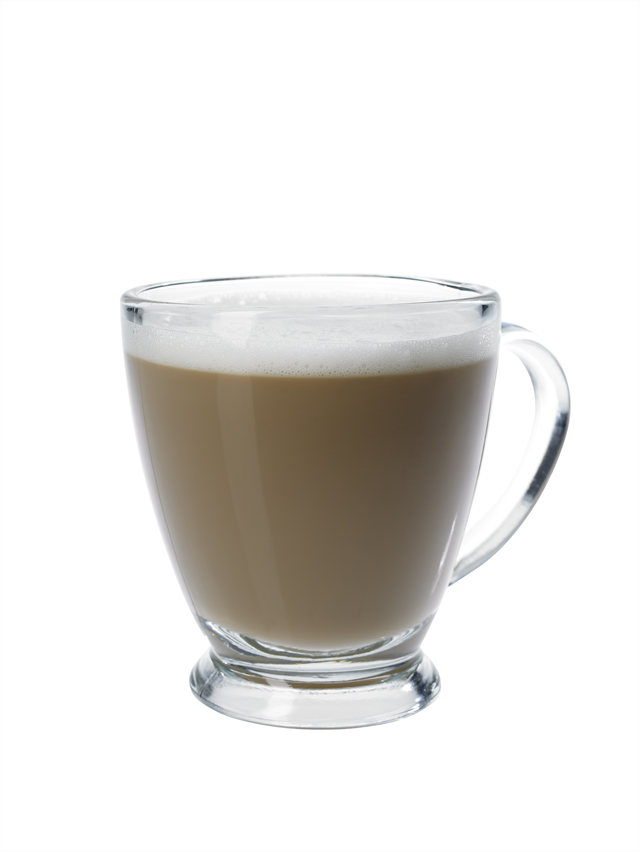

In [1]:
from PIL import Image, ImageOps
from transparent_background import Remover
import numpy as np
from diffusers import ControlNetModel
import os
import torch

# img = Image.open("../data/monin/combined_dataset/test/1725657501_6166165.png").convert('RGB')
img = Image.open("clear-glasses/PARFAIT_mask.jpg").convert("RGB")
# img = Image.open("clear-glasses/1.png").convert("RGB")
# make resolution smaller twice
if img.width > 900:
    img = img.resize((int(img.width/2), int(img.height/2)))
img

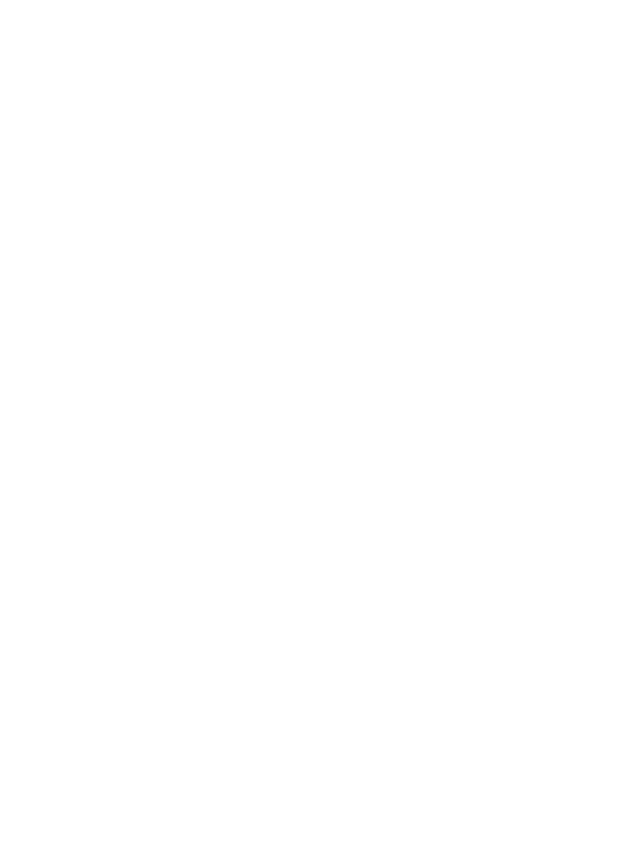

In [2]:
white_img = Image.new('RGB', img.size, color='white')
white_img

In [3]:
def plot_images(images):
    from matplotlib import pyplot as plt
    plt.figure()
    f, axarr = plt.subplots(1, len(images), figsize=(20,10))
    for ax, img in zip(axarr.flatten(), images):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

/opt/conda/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Settings -> Mode=base, Device=cuda:0, Torchscript=disabled
Settings -> Mode=base, Device=cuda:0, Torchscript=disabled


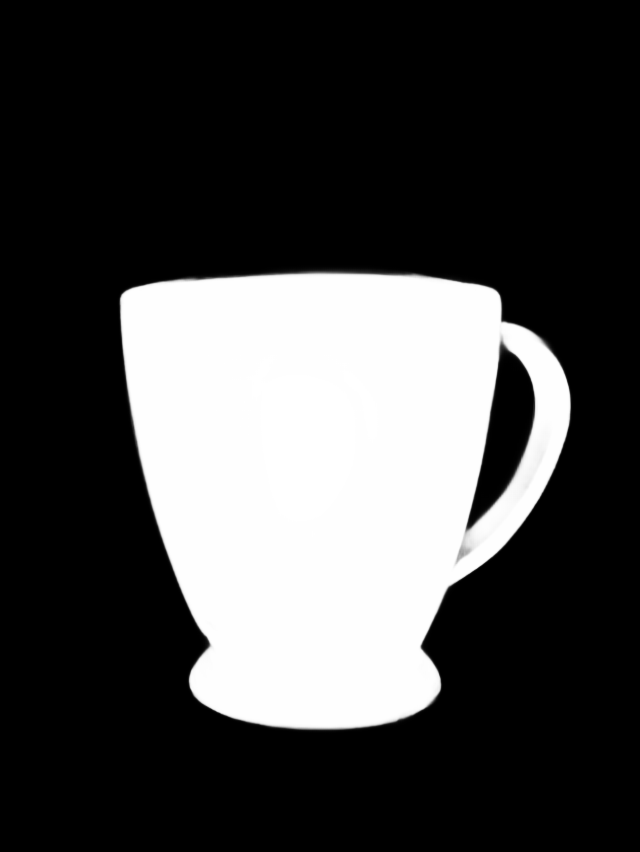

In [4]:
from transparent_background import Remover

remover = Remover() 
remover = Remover(mode='base') 

mask_real = remover.process(img, type='map')
mask_real

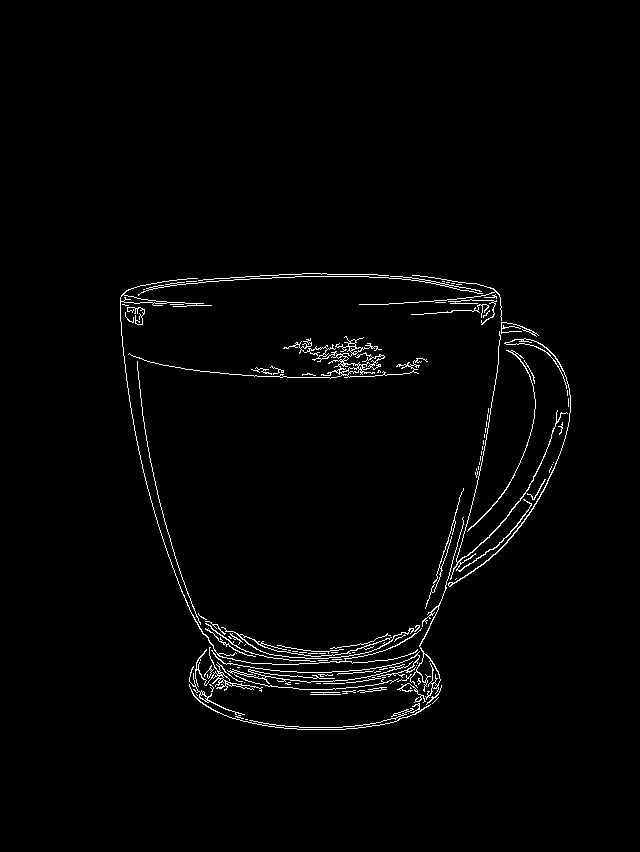

In [5]:
import cv2
import numpy as np
from PIL import Image

image = np.array(img)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

otsu_thresh, _ = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

high_threshold = otsu_thresh
low_threshold = 0.1 * otsu_thresh 

canny_image = cv2.Canny(gray_image, int(low_threshold), int(high_threshold))


canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)
canny_image


In [6]:
torch.cuda.empty_cache()

from diffusers import StableDiffusionControlNetInpaintPipeline


# controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet = ControlNetModel.from_pretrained("model_out", torch_dtype=torch.float16)

pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained("ThreeBibas/sd1.5-napitochki-finetune", torch_dtype=torch.float16, controlnet=controlnet)


pipe = pipe.to("cuda")
# prompt = "Name: 'Luck Of The Irish' Frozen Lemonade; Recipie: 3/4 oz. Monin Pistachio Syrup\n3/4 oz. Monin Ginger Syrup\n2 oz. fresh lemon sour mix\n\nFill serving glass full of ice.\nPour ingredients into blender cup in order listed.\nAdd ice from serving glass, cap, and blend until smooth.\nPour back into serving glass, add garnish and serve.; Category: lemonade"

# prompt = "Name: Bourbon Spice Iced Coffee; Recipie: ice\n1 1/4 oz. bourbon\n1 oz. Monin Iced Coffee Concentrate\n1/2 oz. Monin Cinnamon Bun Syrup\n4 oz. cold milk\n\nFill serving glass full of ice.\nPour ingredients into mixing tin in order listed.\nAdd ice from serving glass.\nCap, shake and pour back into serving glass.\nAdd garnish and serve.; Category: coffee"

# prompt = "Name: Blarney Kissed Coffee; Recipie: 1 1/4 oz. Irish whiskey\n1/4 oz. Monin Spiced Brown Sugar Syrup\n1/2 oz. Monin Irish Cream Syrup\n1 oz. half & half\nFill with fresh brewed coffee\n\nFill serving glass full of hot water to warm glass.\nDiscard hot water and pour ingredients into serving glass in order listed.\nStir gently to mix.\nAdd garnish and serve.; Category: coffee"

# prompt = "Name: Tart Cherry Apple Lemonade; Recipie: 1/2 oz. Monin Apple Syrup\n1/4 oz. Monin Tart Cherry Syrup\n7 oz. lemonade\n\nFill serving glass full of ice.\nPour ingredients into serving glass in order listed.\nPour mixture into mixing tin and back into serving glass to mix.\nAdd garnish and serve.; Category: lemonade"

prompt = "hot cocoa with marshmallows and caramel syrup"


negative_prompt = 'low quality, bad quality, sketches'

images = pipe(prompt=prompt, negative_prompt=negative_prompt, image=white_img, control_image=canny_image, mask_image=mask_real, num_images_per_prompt=6).images

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

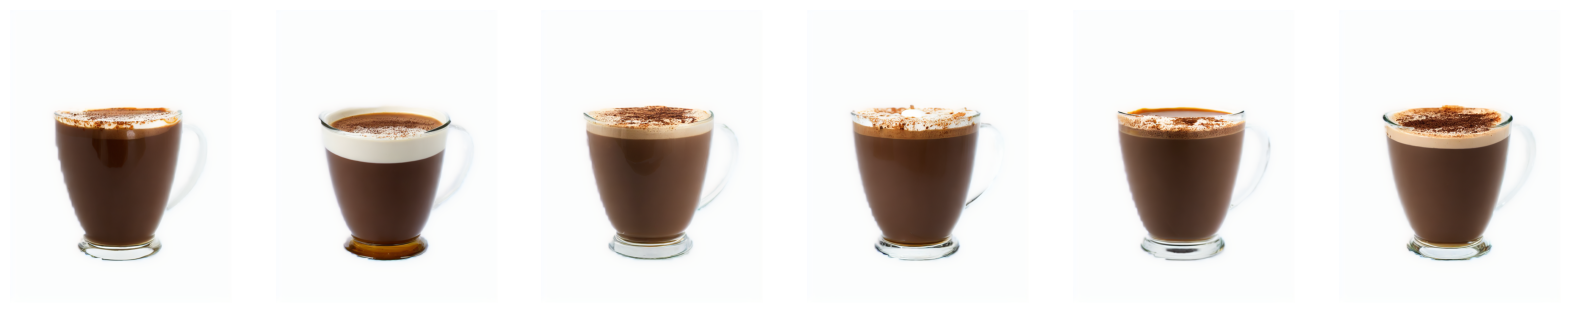

In [7]:
plot_images(images)

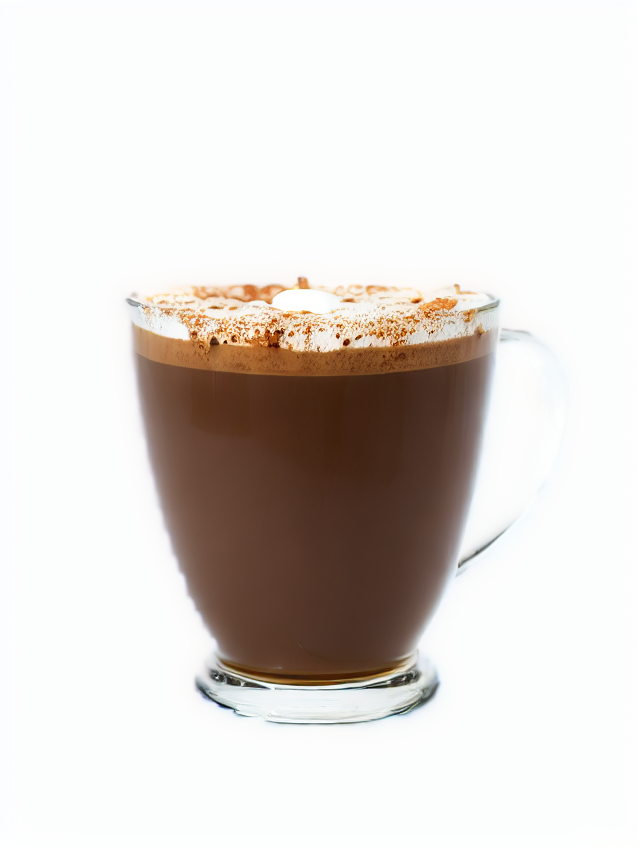

In [8]:
images[3]

In [9]:
controlnet.push_to_hub("ThreeBibas/sd1.5-canny-controlnet-napitochki-finetune-1")

diffusion_pytorch_model.safetensors:   0%|          | 0.00/723M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ThreeBibas/sd1.5-canny-controlnet-napitochki-finetune-1/commit/4fdd1cd6ed1aaf23a77aafc0400bd2074779e09c', commit_message='Upload model', commit_description='', oid='4fdd1cd6ed1aaf23a77aafc0400bd2074779e09c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ThreeBibas/sd1.5-canny-controlnet-napitochki-finetune-1', endpoint='https://huggingface.co', repo_type='model', repo_id='ThreeBibas/sd1.5-canny-controlnet-napitochki-finetune-1'), pr_revision=None, pr_num=None)